# Лаба 4
Работаем

libraries + seed прописываем

In [173]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from enum import Enum

SEED = 501

def set_seed():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.backends.cudnn.enabled = True

    np.random.seed(SEED)

Т.к. в прошлый раз accurracy было близким к 100, генерим данные пожёстче.

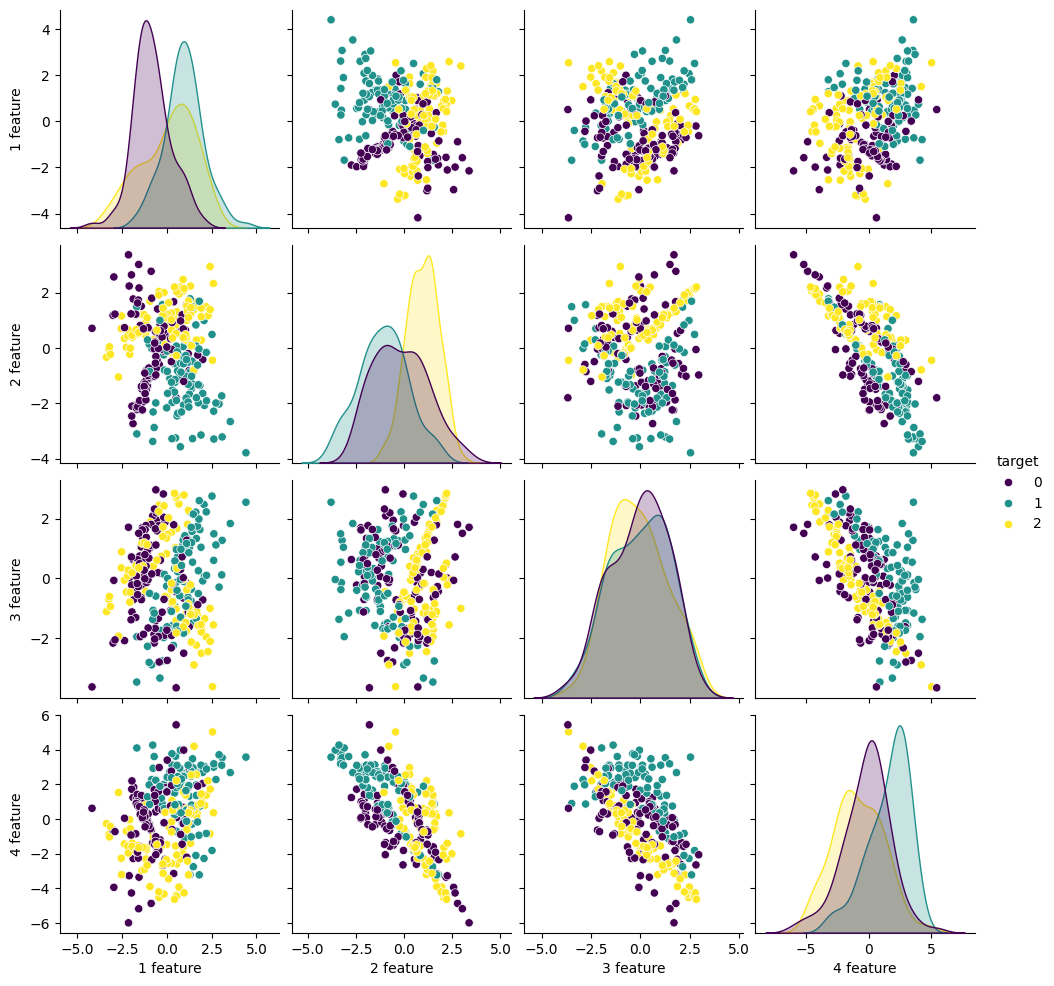

In [174]:
X, y = datasets.make_classification(300, 4, n_informative=3, n_redundant=1, n_repeated=0, n_classes=3, random_state=SEED)

dataframe = pd.DataFrame(X, columns=[f"{i + 1} feature" for i in range(len(X[0]))])
dataframe["target"] = y

sns.pairplot(dataframe, hue="target", palette="viridis")

### Две модели под MLP с dropout и без. Добавил возможность выбора классификатора.

In [206]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.train_losses = []
        self.test_losses = []
    
    def forward(self, x):
        return self.model(x)
    
class MLPWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )
        self.train_losses = []
        self.test_losses = []
    
    def forward(self, x):
        return self.model(x)

class OptimizerName(Enum):
    Adam = "Adam"
    SGD = "SGD"
    RMSProp = "RMSProp"

class ModelType(Enum):
    mlp = "MLP"
    mlpwithdrop = "MLPWithDropout"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

def train_model(optimizer_name: OptimizerName = OptimizerName.Adam, model_type: ModelType = ModelType.mlp, epochs: int = 1000):
    set_seed()
    match(model_type):
        case model_type.mlp:
            model = MLP()
        case model_type.mlpwithdrop:
            model = MLPWithDropout()
    loss = nn.CrossEntropyLoss()
    match(optimizer_name):
        case optimizer_name.Adam:
            optimizer = optim.Adam(model.parameters(), lr=0.01)
        case optimizer_name.SGD:
            optimizer = optim.SGD(model.parameters(), lr=0.01)
        case optimizer_name.RMSProp:
            optimizer = optim.RMSprop(model.parameters(), lr=0.01)
        case _:
            optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss_value = loss(output, y_train_tensor)
        loss_value.backward()
        optimizer.step()
        
        if epoch % 10:
            model.eval()
            model.train_losses.append(loss_value.item())
            with torch.no_grad():
                test_output = model(X_test_tensor)
                test_loss = loss(test_output, y_test_tensor)
                model.test_losses.append((test_loss.item()))


        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss_value.item():.4f}, Testloss: {(model.test_losses[len(model.test_losses) - 1] if len(model.test_losses) > 0 else 1):.4f}')

    return model

# Adam

In [207]:
model = train_model(OptimizerName.Adam, ModelType.mlp, 1000)

Epoch 0, Loss: 0.9705, Testloss: 1.0000
Epoch 100, Loss: 0.1978, Testloss: 0.2326
Epoch 200, Loss: 0.1085, Testloss: 0.1318
Epoch 300, Loss: 0.0750, Testloss: 0.1444
Epoch 400, Loss: 0.0573, Testloss: 0.1780
Epoch 500, Loss: 0.0465, Testloss: 0.2097
Epoch 600, Loss: 0.0391, Testloss: 0.2279
Epoch 700, Loss: 0.0310, Testloss: 0.2596
Epoch 800, Loss: 0.0259, Testloss: 0.2930
Epoch 900, Loss: 0.0219, Testloss: 0.3220


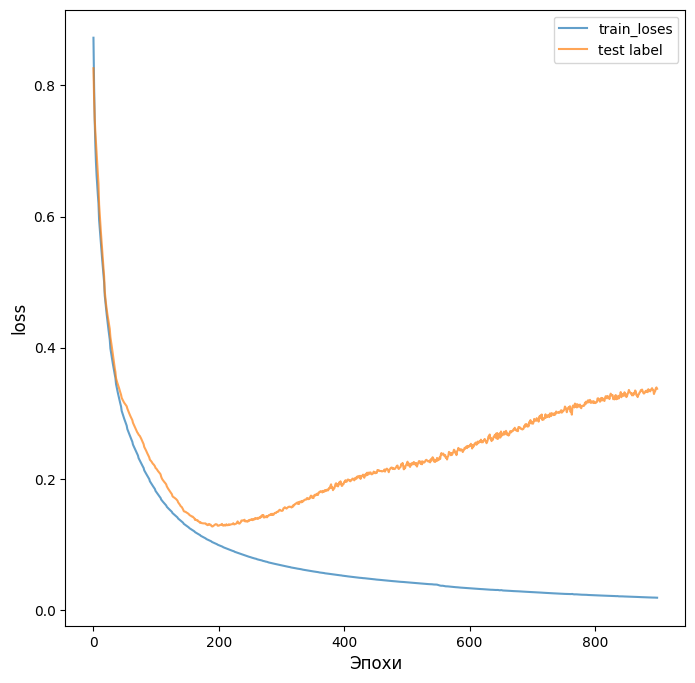

In [177]:
plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test label")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

### Адам конечно был хороший мужик, но тут очевидно, что допустил переобучение.

### Посчитаем `accuracy`

In [178]:
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

accuracy: 0.9166666666666666


### Недурно, но что если взять количество эпох, на которых переобучения не будет.

Epoch 0, Loss: 0.9705, Testloss: 1.0000
Epoch 100, Loss: 0.1978, Testloss: 0.2326
accuracy: 0.9666666666666667


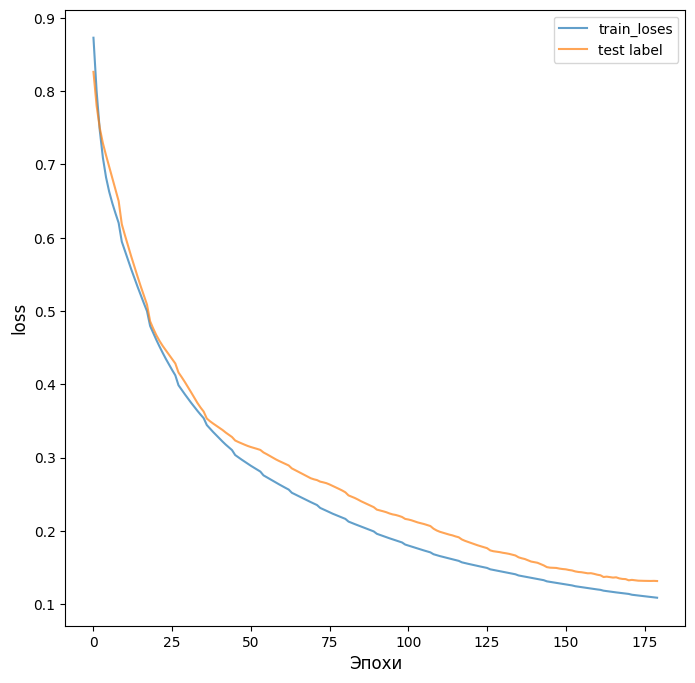

In [ ]:
model = train_model(OptimizerName.Adam, ModelType.mlp, 200)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test label")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

# SGD

Epoch 0, Loss: 0.9705, Testloss: 1.0000
Epoch 100, Loss: 0.7203, Testloss: 0.7594
Epoch 200, Loss: 0.6609, Testloss: 0.7004
Epoch 300, Loss: 0.6291, Testloss: 0.6661
Epoch 400, Loss: 0.6055, Testloss: 0.6401
Epoch 500, Loss: 0.5853, Testloss: 0.6181
Epoch 600, Loss: 0.5670, Testloss: 0.5980
Epoch 700, Loss: 0.5497, Testloss: 0.5795
Epoch 800, Loss: 0.5338, Testloss: 0.5624
Epoch 900, Loss: 0.5192, Testloss: 0.5467
0.85


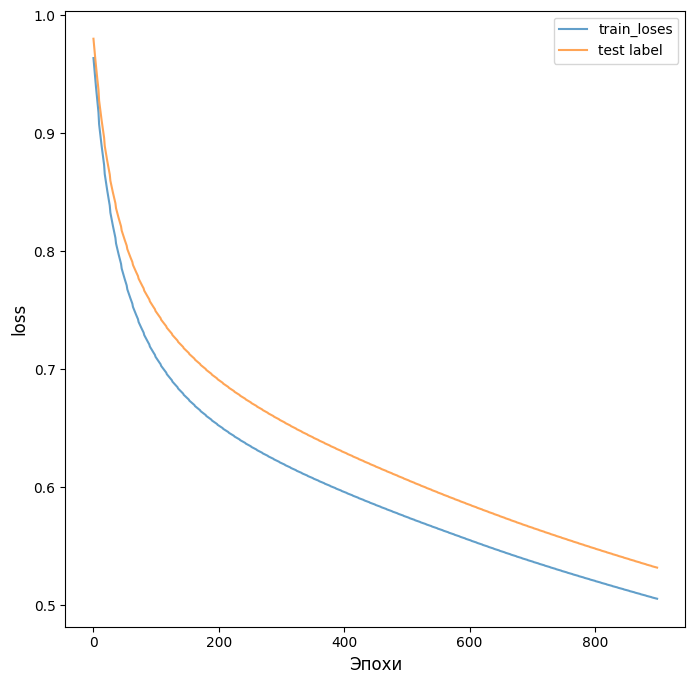

In [ ]:
model = train_model(OptimizerName.SGD, ModelType.mlp, 1000)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test label")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

model.eval() 
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

### Видно, что `loss` далёк от идеала, так что немного увеличим кол-во эпох...

Epoch 0, Loss: 0.9705, Testloss: 1.0000
Epoch 100, Loss: 0.7203, Testloss: 0.7594
Epoch 200, Loss: 0.6609, Testloss: 0.7004
Epoch 300, Loss: 0.6291, Testloss: 0.6661
Epoch 400, Loss: 0.6055, Testloss: 0.6401
Epoch 500, Loss: 0.5853, Testloss: 0.6181
Epoch 600, Loss: 0.5670, Testloss: 0.5980
Epoch 700, Loss: 0.5497, Testloss: 0.5795
Epoch 800, Loss: 0.5338, Testloss: 0.5624
Epoch 900, Loss: 0.5192, Testloss: 0.5467
Epoch 1000, Loss: 0.5055, Testloss: 0.5320
Epoch 1100, Loss: 0.4926, Testloss: 0.5183
Epoch 1200, Loss: 0.4807, Testloss: 0.5053
Epoch 1300, Loss: 0.4695, Testloss: 0.4929
Epoch 1400, Loss: 0.4590, Testloss: 0.4811
Epoch 1500, Loss: 0.4492, Testloss: 0.4699
Epoch 1600, Loss: 0.4399, Testloss: 0.4592
Epoch 1700, Loss: 0.4312, Testloss: 0.4492
Epoch 1800, Loss: 0.4229, Testloss: 0.4399
Epoch 1900, Loss: 0.4152, Testloss: 0.4312
Epoch 2000, Loss: 0.4080, Testloss: 0.4234
Epoch 2100, Loss: 0.4012, Testloss: 0.4161
Epoch 2200, Loss: 0.3948, Testloss: 0.4095
Epoch 2300, Loss: 0.388

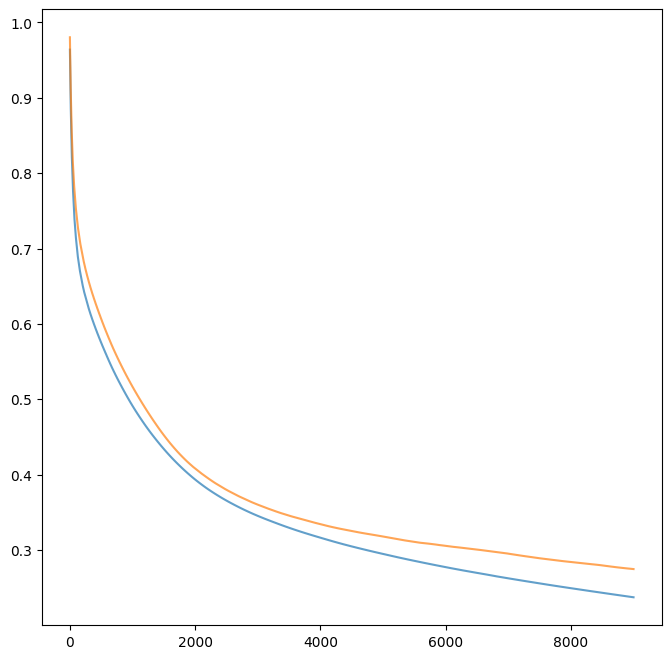

In [ ]:
model = train_model(OptimizerName.SGD, ModelType.mlp, 10000)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test_losses")

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

### Стало хуже.

# RMSProp

Epoch 0, Loss: 0.9705, Testloss: 1.0000
Epoch 100, Loss: 0.1919, Testloss: 0.2222
Epoch 200, Loss: 0.1335, Testloss: 0.1485
Epoch 300, Loss: 0.1104, Testloss: 0.1400
Epoch 400, Loss: 0.0938, Testloss: 0.1272
Epoch 500, Loss: 0.0822, Testloss: 0.1437
Epoch 600, Loss: 0.0811, Testloss: 0.1804
Epoch 700, Loss: 0.0614, Testloss: 0.1685
Epoch 800, Loss: 0.0674, Testloss: 0.1885
Epoch 900, Loss: 0.0524, Testloss: 0.1942
0.95


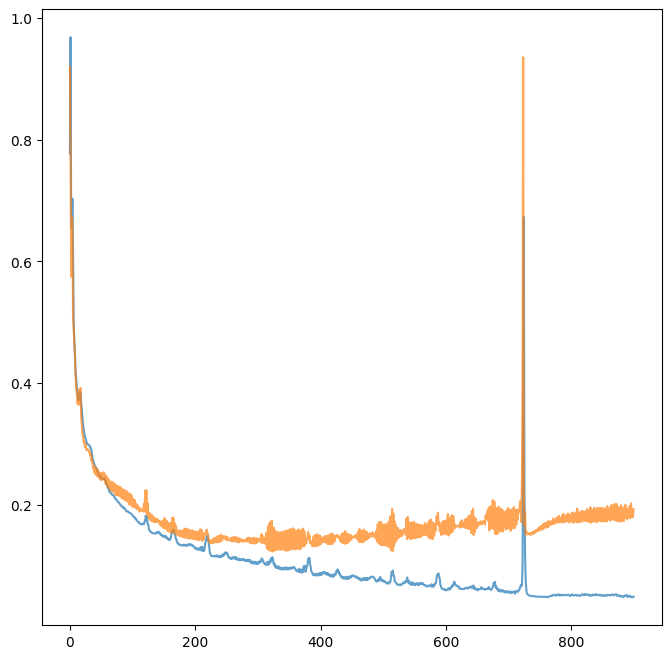

In [ ]:
model = train_model(OptimizerName.RMSProp, ModelType.mlp, 1000)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test_losses")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

### График loss очень нестабильный, можно увидеть резкие колебания. Но точность отличная, на уровне Adam.

### Выводы:
1. `Adam` и `RMSProp` выдают отличные результаты. Но `Adam` склонен к переобучению, а `RMSProp` к большим колебаниям в loss.
2. `SGD` выдаёт результаты хуже, хотя и является самым стабильным классификатором. Отличительной особенностью является то, что с уменьшение loss точность остаётся такой же. Как мне объяснил `deepseek` вероятно это происходит потому что `SGD` склонен колебаться в пограничным точках.

# Dropout

Epoch 0, Loss: 0.9953, Testloss: 1.0000
Epoch 100, Loss: 0.3099, Testloss: 0.2433
Epoch 200, Loss: 0.2781, Testloss: 0.2085
Epoch 300, Loss: 0.2254, Testloss: 0.1860
Epoch 400, Loss: 0.2209, Testloss: 0.1798
Epoch 500, Loss: 0.1863, Testloss: 0.1722
Epoch 600, Loss: 0.1671, Testloss: 0.1623
Epoch 700, Loss: 0.1946, Testloss: 0.1535
Epoch 800, Loss: 0.1714, Testloss: 0.1643
Epoch 900, Loss: 0.1595, Testloss: 0.1654
accuracy: 0.95


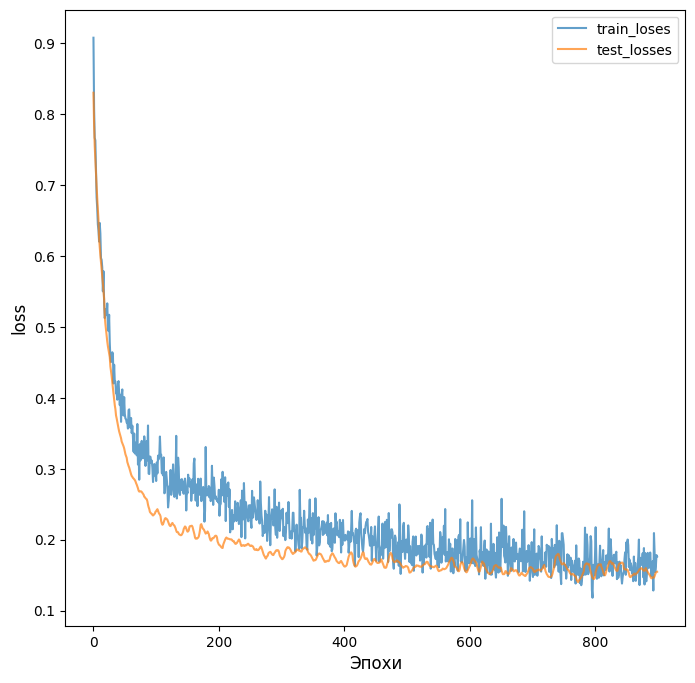

In [209]:
model = train_model(OptimizerName.Adam, ModelType.mlpwithdrop, 1000)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test_losses")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

Epoch 0, Loss: 0.9953, Testloss: 1.0000
Epoch 100, Loss: 0.7588, Testloss: 0.7624
Epoch 200, Loss: 0.6985, Testloss: 0.7058
Epoch 300, Loss: 0.6673, Testloss: 0.6733
Epoch 400, Loss: 0.6504, Testloss: 0.6487
Epoch 500, Loss: 0.6249, Testloss: 0.6280
Epoch 600, Loss: 0.6162, Testloss: 0.6084
Epoch 700, Loss: 0.6113, Testloss: 0.5909
Epoch 800, Loss: 0.5974, Testloss: 0.5734
Epoch 900, Loss: 0.5475, Testloss: 0.5587
Epoch 1000, Loss: 0.5371, Testloss: 0.5444
Epoch 1100, Loss: 0.5388, Testloss: 0.5309
Epoch 1200, Loss: 0.5291, Testloss: 0.5187
Epoch 1300, Loss: 0.5189, Testloss: 0.5055
Epoch 1400, Loss: 0.5140, Testloss: 0.4937
Epoch 1500, Loss: 0.5078, Testloss: 0.4830
Epoch 1600, Loss: 0.5144, Testloss: 0.4714
Epoch 1700, Loss: 0.5013, Testloss: 0.4617
Epoch 1800, Loss: 0.5158, Testloss: 0.4527
Epoch 1900, Loss: 0.4830, Testloss: 0.4441
Epoch 2000, Loss: 0.4869, Testloss: 0.4360
Epoch 2100, Loss: 0.4610, Testloss: 0.4290
Epoch 2200, Loss: 0.4520, Testloss: 0.4223
Epoch 2300, Loss: 0.437

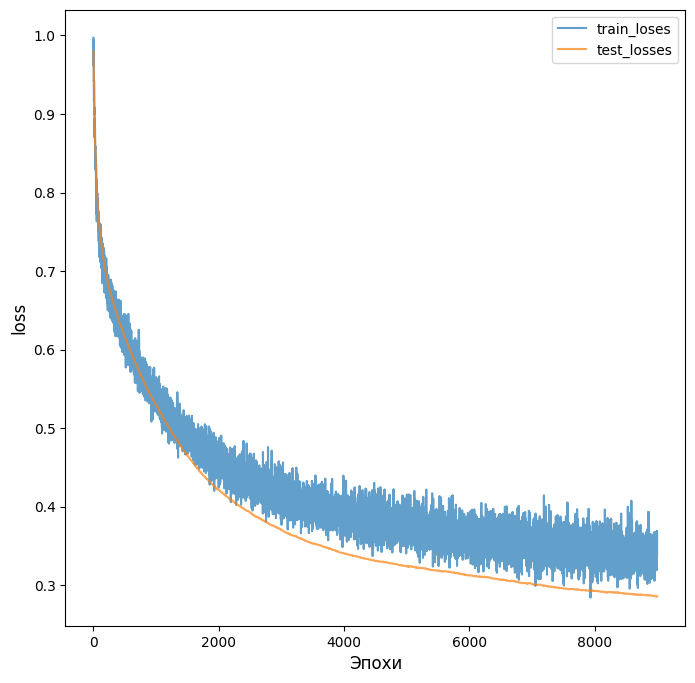

In [211]:
model = train_model(OptimizerName.SGD, ModelType.mlpwithdrop, 10000)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test_losses")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

Epoch 0, Loss: 0.9953, Testloss: 1.0000
Epoch 100, Loss: 0.2827, Testloss: 0.2402
Epoch 200, Loss: 0.2279, Testloss: 0.1786
Epoch 300, Loss: 0.2288, Testloss: 0.1775
Epoch 400, Loss: 0.1959, Testloss: 0.1688
Epoch 500, Loss: 0.1906, Testloss: 0.1457
Epoch 600, Loss: 0.1620, Testloss: 0.1774
Epoch 700, Loss: 0.1878, Testloss: 0.1796
Epoch 800, Loss: 0.1429, Testloss: 0.1524
Epoch 900, Loss: 0.1441, Testloss: 0.1603
accuracy: 0.95


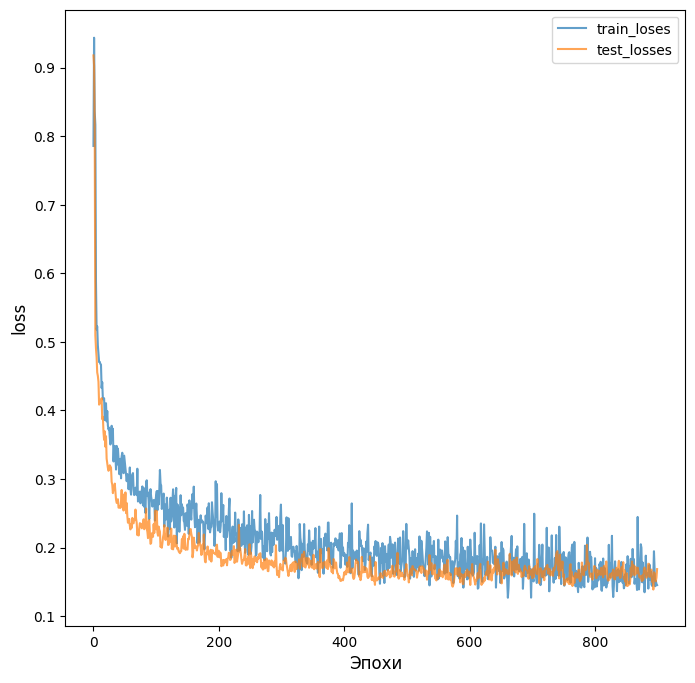

In [212]:
model = train_model(OptimizerName.RMSProp, ModelType.mlpwithdrop, 1000)

plt.figure(figsize=(8, 8))
plt.plot(model.train_losses, alpha=0.7, label="train_loses")
plt.plot(model.test_losses, alpha=0.7, label="test_losses")
plt.xlabel("Эпохи", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend()

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1)
accuracy = np.mean(predictions.numpy() == y_test)
print(f"accuracy: {accuracy}")

### C `dropout` картина сильно не поменялась, но можно заметить, что:
1. `Adam` перестал переобучаться.
2. `RMSProp` перестал делать огромные скачки в loss.